This is evaluate all the models (random forest, naives baiyes and svm) on the test set

In [1]:
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, 
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


In [3]:
data = pd.read_csv('cleaned_data.csv')
print(f"Data loaded: {data.shape}")
print(f"Columns: {list(data.columns)}")

Data loaded: (17880, 17)
Columns: ['title', 'location', 'department', 'company_profile', 'description', 'requirements', 'benefits', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'industry', 'function', 'fraudulent', 'combined_text', 'cleaned_text']


In [4]:
data.head(20)

,title,location,department,company_profile,description,requirements,benefits,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,combined_text,cleaned_text
0,Marketing Intern,United States,Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,Unknown,Yes,No,Other,Internship,Other,Other,Marketing,0,Marketing Intern Marketing United States We're...,marketing intern marketing united state create...
1,Customer Service - Cloud Video Production,New Zealand,Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Yes,No,Full-time,Not Applicable,Other,Marketing,Customer Service,0,Customer Service - Cloud Video Production Succ...,customer service cloud video production succes...
2,Commissioning Machinery Assistant (CMA),United States,Unknown,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,Unknown,Yes,No,Unknown,Unknown,Other,Other,Unknown,0,Commissioning Machinery Assistant (CMA) Unknow...,commissioning machinery assistant cma unknown ...
3,Account Executive - Washington DC,United States,Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Yes,No,Full-time,Mid-Senior level,Bachelor,Technology,Sales,0,Account Executive - Washington DC Sales United...,account executive washington dc sale united st...
4,Bill Review Manager,United States,Unknown,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Yes,Yes,Full-time,Mid-Senior level,Bachelor,Healthcare,Health Care Provider,0,Bill Review Manager Unknown United States Spot...,bill review manager unknown united state spots...
5,Accounting Clerk,United States,Unknown,Unknown,Job OverviewApex is an environmental consultin...,Unknown,Unknown,No,No,Unknown,Unknown,Other,Other,Unknown,0,Accounting Clerk Unknown United States Unknown...,accounting clerk unknown united state unknown ...
6,Head of Content (m/f),Germany,ANDROIDPIT,"Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,Your Know-How: ...,Your Benefits: Being part of a fast-growing co...,Yes,Yes,Full-time,Mid-Senior level,Master,Media,Management,0,Head of Content (m/f) ANDROIDPIT Germany Found...,head content androidpit germany founded thefon...
7,Lead Guest Service Specialist,United States,Unknown,Airenvy’s mission is to provide lucrative yet ...,Who is Airenvy?Hey there! We are seasoned entr...,"Experience with CRM software, live chat, and p...",Competitive Pay. You'll be able to eat steak e...,Yes,Yes,Unknown,Unknown,Other,Other,Unknown,0,Lead Guest Service Specialist Unknown Unite...,lead guest service specialist unknown united s...
8,HP BSM SME,United States,Unknown,Solutions3 is a woman-owned small business who...,Implementation/Configuration/Testing/Training ...,MUST BE A US CITIZEN.An active TS/SCI clearanc...,Unknown,Yes,Yes,Full-time,Associate,Other,Technology,Unknown,0,HP BSM SME Unknown United States Solutions3 is...,hp bsm sme unknown united state small business...
9,Customer Service Associate - Part Time,United States,Unknown,"Novitex Enterprise Solutions, formerly Pitney ...",The Customer Service Associate will be based i...,Minimum Requirements:Minimum of 6 months custo...,Unknown,Yes,No,Part-time,Entry level,High School,Finance,Customer Service,0,Customer Service Associate - Part Time Unknow...,customer service associate part time unknown u...


In [5]:
print(f"\nTarget distribution:")
print(data['fraudulent'].value_counts())
print(f"Fraud percentage: {data['fraudulent'].mean():.2%}")


Target distribution:
fraudulent
0    17014
1      866
Name: count, dtype: int64
Fraud percentage: 4.84%


In [6]:
model_dir = "models_notebook"
vectorizer = joblib.load(os.path.join(model_dir, "vectorizer.joblib"))
print("TF-IDF vectorizer loaded successfully!")

TF-IDF vectorizer loaded successfully!


In [7]:
X = data.drop(columns=['fraudulent'])
y = data['fraudulent']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [9]:
X_test_vectorized = vectorizer.transform(X_test['cleaned_text'])

print(f"Test set prepared: {X_test_vectorized.shape}")
print(f"Test target distribution: {y_test.value_counts()}")

Test set prepared: (5364, 5000)
Test target distribution: fraudulent
0    5104
1     260
Name: count, dtype: int64


In [10]:
model_configs = {
    'original': 'Original (No Sampling)',
    'hybrid': 'SMOTE-ENN Hybrid',
}

In [11]:
classifier_names = ['random_forest', 'naive_bayes', 'support_vector_machine']
display_names = ['Random Forest', 'Naive Bayes', 'Support Vector Machine']

In [12]:
models = {}
for sampling_type in model_configs.keys():
    models[sampling_type] = {}
    for clf_name, display_name in zip(classifier_names, display_names):
        model_path = os.path.join(model_dir, f"{clf_name}_{sampling_type}.joblib")
        if os.path.exists(model_path):
            models[sampling_type][display_name] = joblib.load(model_path)
            print(f"Loaded: {display_name} - {model_configs[sampling_type]}")
        else:
            print(f"Warning: Model not found at {model_path}")

print(f"\nTotal models loaded: {sum(len(models[k]) for k in models.keys())}")

Loaded: Random Forest - Original (No Sampling)
Loaded: Naive Bayes - Original (No Sampling)
Loaded: Support Vector Machine - Original (No Sampling)
Loaded: Random Forest - SMOTE-ENN Hybrid
Loaded: Naive Bayes - SMOTE-ENN Hybrid
Loaded: Support Vector Machine - SMOTE-ENN Hybrid

Total models loaded: 6


In [21]:
# Cell 1: Enhanced Evaluation Function with All Required Metrics
def evaluate_model_detailed(model, X_test, y_test, model_name="Model"):
    """Evaluate a single model with all required metrics and detailed analysis"""
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate all metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    # Generate classification report
    class_report = classification_report(y_test, y_pred, output_dict=True)
    class_report_str = classification_report(y_test, y_pred)
    
    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Calculate ROC curve data
    if y_pred_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        roc_data = {'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds}
    else:
        roc_data = None
    
    # Return comprehensive results
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'classification_report': class_report,
        'classification_report_str': class_report_str,
        'confusion_matrix': conf_matrix,
        'roc_data': roc_data
    }

In [22]:
def plot_detailed_confusion_matrix(conf_matrix, model_name):
    """Plot detailed confusion matrix with percentages"""
    plt.figure(figsize=(8, 6))
    
    # Calculate percentages
    conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
    
    # Create annotations with both counts and percentages
    annotations = []
    for i in range(conf_matrix.shape[0]):
        row = []
        for j in range(conf_matrix.shape[1]):
            count = conf_matrix[i, j]
            percent = conf_matrix_percent[i, j]
            row.append(f'{count}\n({percent:.1f}%)')
        annotations.append(row)
    
    sns.heatmap(conf_matrix, annot=annotations, fmt='', cmap='Blues',
                xticklabels=['Non-Fraud', 'Fraud'],
                yticklabels=['Non-Fraud', 'Fraud'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()


In [23]:
def plot_individual_roc_curve(roc_data, model_name, auc_score):
    """Plot ROC curve for individual model"""
    plt.figure(figsize=(8, 6))
    
    if roc_data is not None:
        plt.plot(roc_data['fpr'], roc_data['tpr'], 
                linewidth=2, label=f'ROC Curve (AUC = {auc_score:.4f})')
        plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
        
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

In [24]:
print("=" * 80)
print("DETAILED EVALUATION FOR EVERY MODEL")
print("=" * 80)

# Store detailed results for each model
detailed_results = {}
summary_results = []

model_counter = 1
total_models = sum(len(models[k]) for k in models.keys())

for sampling_type, sampling_name in model_configs.items():
    print(f"\n{'='*60}")
    print(f"SAMPLING STRATEGY: {sampling_name.upper()}")
    print(f"{'='*60}")
    
    if sampling_type in models and models[sampling_type]:
        for clf_name, model in models[sampling_type].items():
            model_full_name = f"{clf_name} ({sampling_name})"
            
            print(f"\n[{model_counter}/{total_models}] EVALUATING: {model_full_name}")
            print("-" * 50)
            
            # Detailed evaluation
            eval_results = evaluate_model_detailed(
                model, X_test_vectorized, y_test, model_full_name
            )
            
            detailed_results[model_full_name] = eval_results
            
            # Add to summary
            summary_results.append({
                'Model': model_full_name,
                'Classifier': clf_name,
                'Sampling': sampling_name,
                'Accuracy': eval_results['accuracy'],
                'Precision': eval_results['precision'],
                'Recall': eval_results['recall'],
                'F1-Score': eval_results['f1_score'],
                'ROC-AUC': eval_results['roc_auc']
            })
            
            model_counter += 1
            
print(f"\n✅ Detailed evaluation completed for {len(detailed_results)} models!")

DETAILED EVALUATION FOR EVERY MODEL

SAMPLING STRATEGY: ORIGINAL (NO SAMPLING)

[1/6] EVALUATING: Random Forest (Original (No Sampling))
--------------------------------------------------

[2/6] EVALUATING: Naive Bayes (Original (No Sampling))
--------------------------------------------------

[3/6] EVALUATING: Support Vector Machine (Original (No Sampling))
--------------------------------------------------

SAMPLING STRATEGY: SMOTE-ENN HYBRID

[4/6] EVALUATING: Random Forest (SMOTE-ENN Hybrid)
--------------------------------------------------

[5/6] EVALUATING: Naive Bayes (SMOTE-ENN Hybrid)
--------------------------------------------------

[6/6] EVALUATING: Support Vector Machine (SMOTE-ENN Hybrid)
--------------------------------------------------

✅ Detailed evaluation completed for 6 models!



DETAILED REPORT EXAMPLE: Random Forest (Original (No Sampling))

📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      5104
           1       0.70      0.75      0.72       260

    accuracy                           0.97      5364
   macro avg       0.84      0.87      0.85      5364
weighted avg       0.97      0.97      0.97      5364



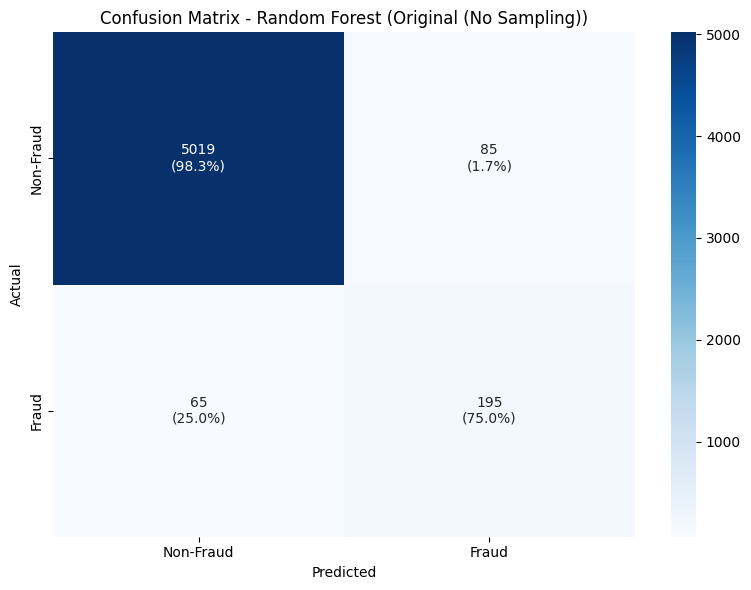

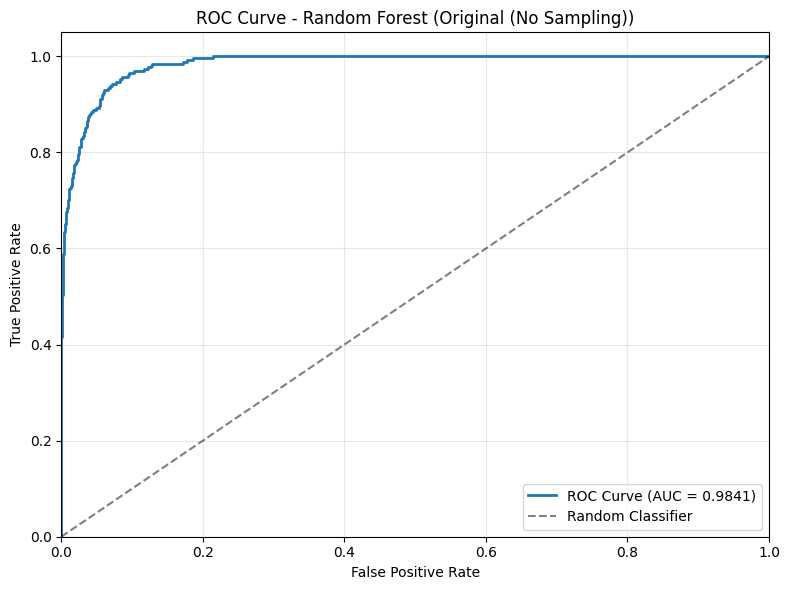

In [28]:
first_model_name = list(detailed_results.keys())[0]
first_eval = detailed_results[first_model_name]

print(f"\n{'='*70}")
print(f"DETAILED REPORT EXAMPLE: {first_model_name}")
print(f"{'='*70}")
# Performance metrics
print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
print(first_eval['classification_report_str'])

# Confusion matrix breakdown
tn, fp, fn, tp = first_eval['confusion_matrix'].ravel()


# Plot visualizations
plot_detailed_confusion_matrix(first_eval['confusion_matrix'], first_model_name)
plot_individual_roc_curve(first_eval['roc_data'], first_model_name, first_eval['roc_auc'])


DETAILED REPORT EXAMPLE: Naive Bayes (Original (No Sampling))

📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5104
           1       0.65      0.39      0.49       260

    accuracy                           0.96      5364
   macro avg       0.81      0.69      0.73      5364
weighted avg       0.95      0.96      0.96      5364



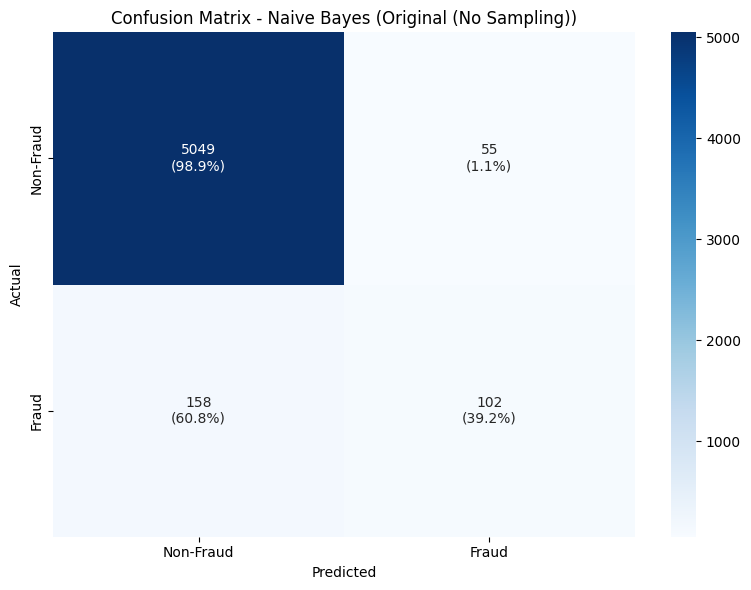

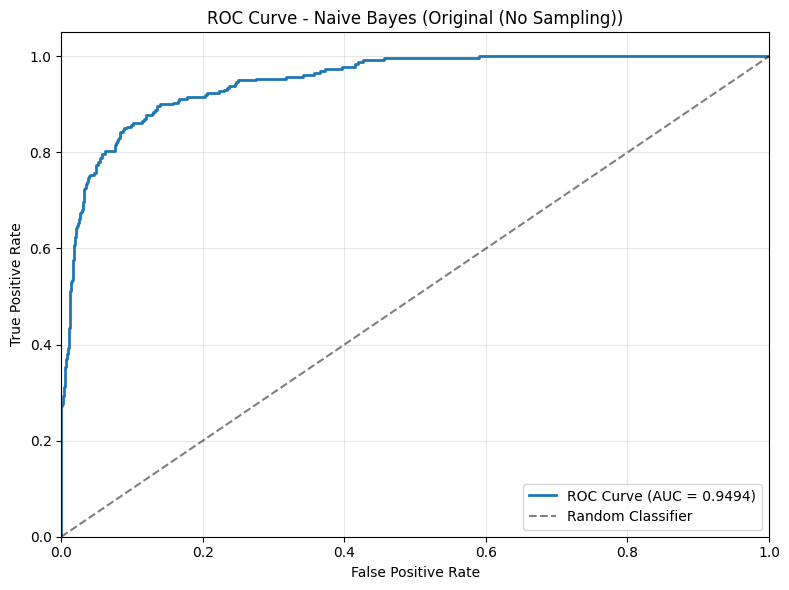

In [29]:
model2_name = list(detailed_results.keys())[1]
model2_eval = detailed_results[model2_name]

print(f"\n{'='*70}")
print(f"DETAILED REPORT EXAMPLE: {model2_name}")
print(f"{'='*70}")
# Performance metrics
print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
print(model2_eval['classification_report_str'])

# Confusion matrix breakdown
tn, fp, fn, tp = model2_eval['confusion_matrix'].ravel()


# Plot visualizations
plot_detailed_confusion_matrix(model2_eval['confusion_matrix'], model2_name)
plot_individual_roc_curve(model2_eval['roc_data'], model2_name, model2_eval['roc_auc'])


DETAILED REPORT EXAMPLE: Support Vector Machine (Original (No Sampling))

📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5104
           1       1.00      0.66      0.79       260

    accuracy                           0.98      5364
   macro avg       0.99      0.83      0.89      5364
weighted avg       0.98      0.98      0.98      5364



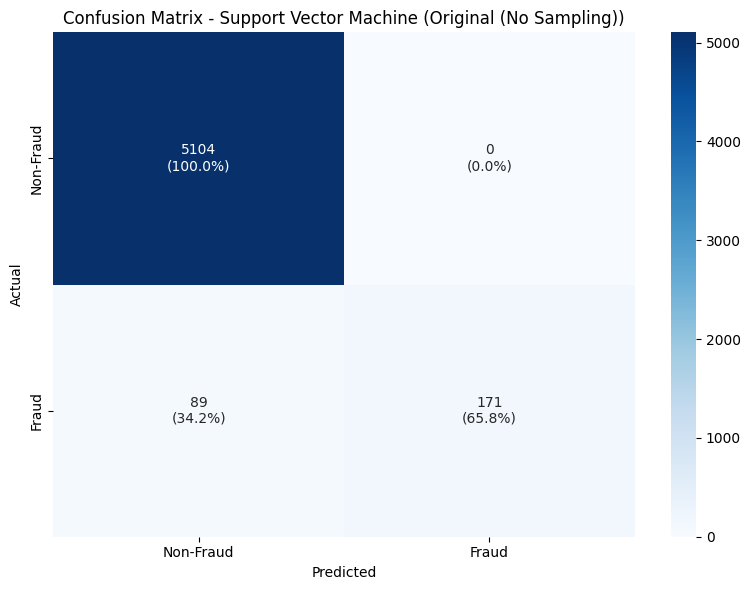

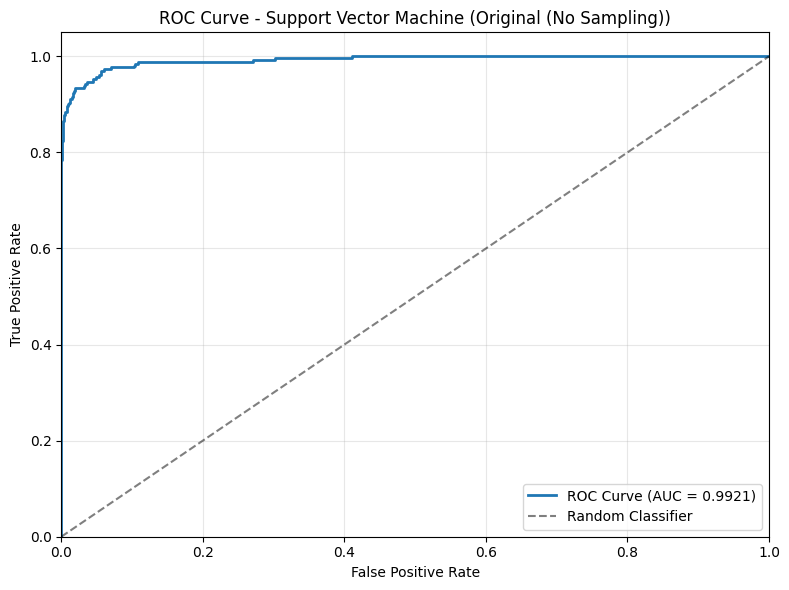

In [31]:
model3_name = list(detailed_results.keys())[2]
model3_eval = detailed_results[model3_name]

print(f"\n{'='*70}")
print(f"DETAILED REPORT EXAMPLE: {model3_name}")
print(f"{'='*70}")
# Performance metrics
print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
print(model3_eval['classification_report_str'])

# Confusion matrix breakdown
tn, fp, fn, tp = model3_eval['confusion_matrix'].ravel()


# Plot visualizations
plot_detailed_confusion_matrix(model3_eval['confusion_matrix'], model3_name)
plot_individual_roc_curve(model3_eval['roc_data'], model3_name, model3_eval['roc_auc'])


DETAILED REPORT EXAMPLE: Random Forest (SMOTE-ENN Hybrid)

📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      5104
           1       0.49      0.88      0.63       260

    accuracy                           0.95      5364
   macro avg       0.74      0.92      0.80      5364
weighted avg       0.97      0.95      0.96      5364



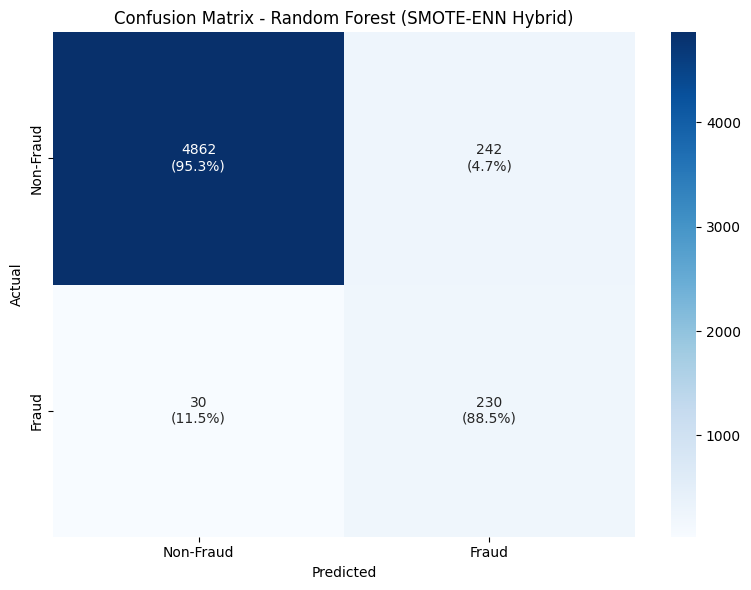

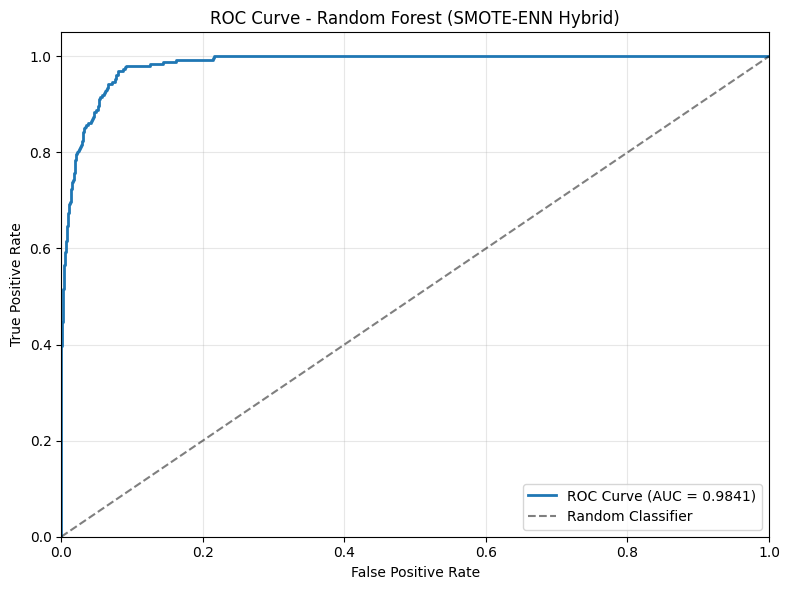

In [32]:
model4_name = list(detailed_results.keys())[3]
model4_eval = detailed_results[model4_name]

print(f"\n{'='*70}")
print(f"DETAILED REPORT EXAMPLE: {model4_name}")
print(f"{'='*70}")
# Performance metrics
print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
print(model4_eval['classification_report_str'])

# Confusion matrix breakdown
tn, fp, fn, tp = model4_eval['confusion_matrix'].ravel()


# Plot visualizations
plot_detailed_confusion_matrix(model4_eval['confusion_matrix'], model4_name)
plot_individual_roc_curve(model4_eval['roc_data'], model4_name, model4_eval['roc_auc'])


DETAILED REPORT EXAMPLE: Naive Bayes (SMOTE-ENN Hybrid)

📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92      5104
           1       0.26      0.97      0.40       260

    accuracy                           0.86      5364
   macro avg       0.63      0.91      0.66      5364
weighted avg       0.96      0.86      0.90      5364



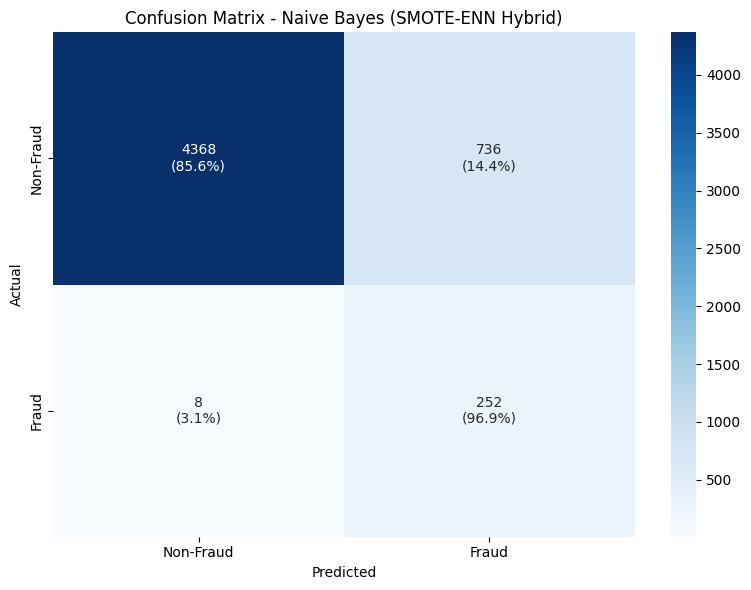

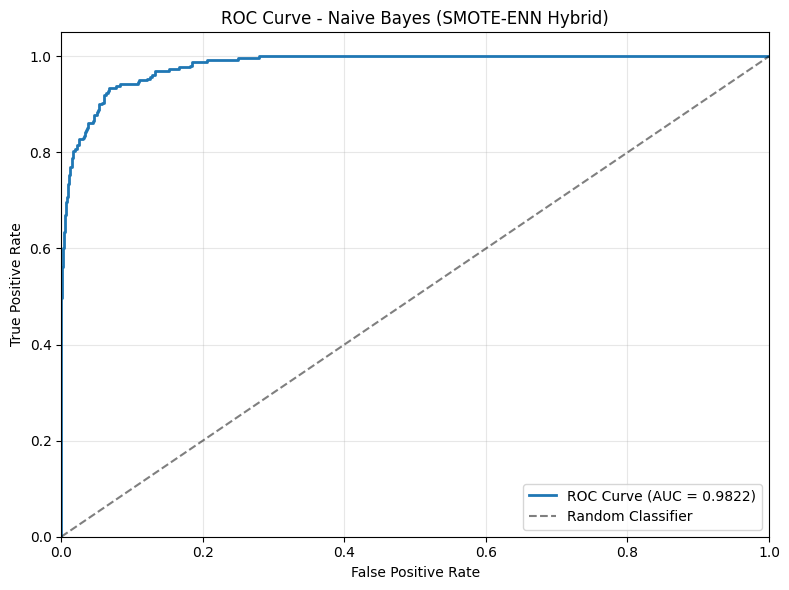

In [33]:
model5_name = list(detailed_results.keys())[4]
model5_eval = detailed_results[model5_name]

print(f"\n{'='*70}")
print(f"DETAILED REPORT EXAMPLE: {model5_name}")
print(f"{'='*70}")
# Performance metrics
print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
print(model5_eval['classification_report_str'])

# Confusion matrix breakdown
tn, fp, fn, tp = model5_eval['confusion_matrix'].ravel()

# Plot visualizations
plot_detailed_confusion_matrix(model5_eval['confusion_matrix'], model5_name)
plot_individual_roc_curve(model5_eval['roc_data'], model5_name, model5_eval['roc_auc'])


DETAILED REPORT EXAMPLE: Support Vector Machine (SMOTE-ENN Hybrid)

📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5104
           1       0.75      0.86      0.80       260

    accuracy                           0.98      5364
   macro avg       0.87      0.92      0.89      5364
weighted avg       0.98      0.98      0.98      5364



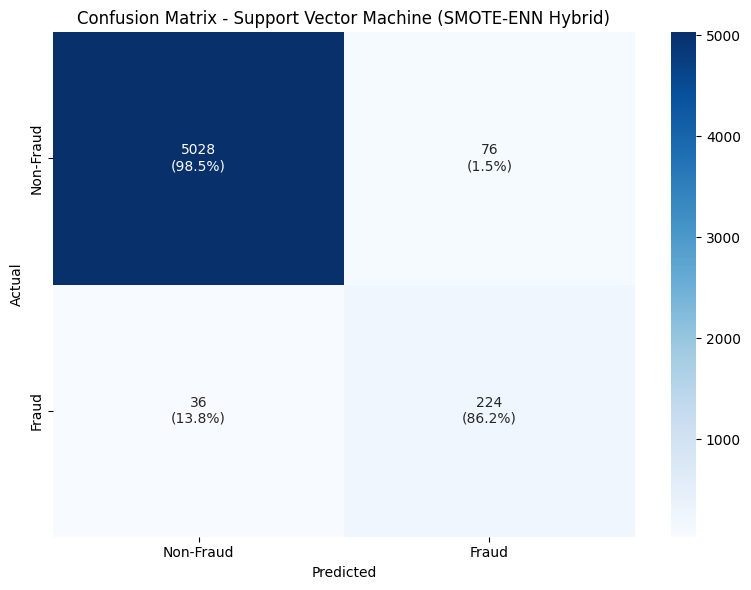

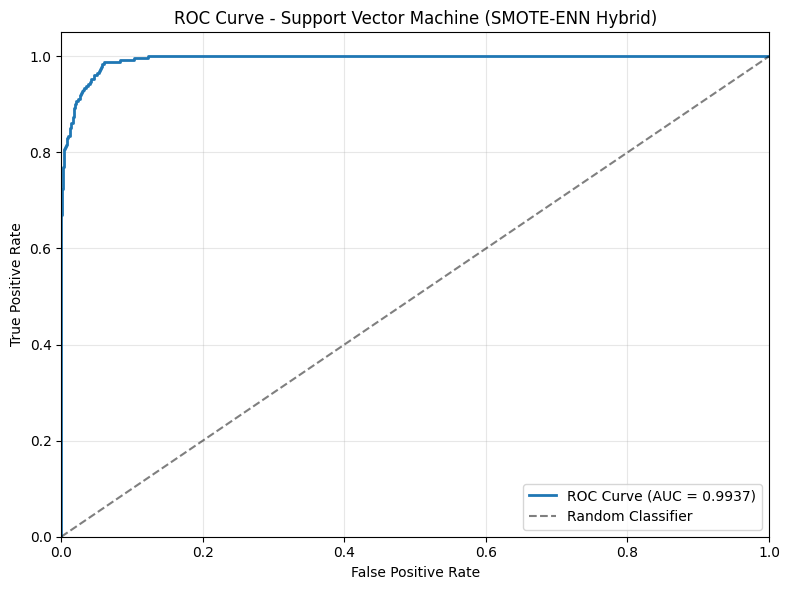

In [45]:
model6_name = list(detailed_results.keys())[5]
model6_eval = detailed_results[model6_name]

print(f"\n{'='*70}")
print(f"DETAILED REPORT EXAMPLE: {model6_name}")
print(f"{'='*70}")
# Performance metrics
print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
print(model6_eval['classification_report_str'])

# Confusion matrix breakdown
tn, fp, fn, tp = model6_eval['confusion_matrix'].ravel()


# Plot visualizations
plot_detailed_confusion_matrix(model6_eval['confusion_matrix'], model6_name)
plot_individual_roc_curve(model6_eval['roc_data'], model6_name, model6_eval['roc_auc'])

In [42]:
summary_df = pd.DataFrame(summary_results)

# Drop unwanted columns if they exist
summary_df = summary_df.drop(columns=["Classifier", "Sampling"], errors="ignore")

print(f"\n{'='*10}")
print(" SUMMARY ")
print(f"{'='*10}")
print(summary_df.to_string(index=False, float_format="%.4f"))



 SUMMARY 
                                          Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
         Random Forest (Original (No Sampling))    0.9720     0.6964  0.7500    0.7222   0.9841
           Naive Bayes (Original (No Sampling))    0.9603     0.6497  0.3923    0.4892   0.9494
Support Vector Machine (Original (No Sampling))    0.9834     1.0000  0.6577    0.7935   0.9921
               Random Forest (SMOTE-ENN Hybrid)    0.9493     0.4873  0.8846    0.6284   0.9841
                 Naive Bayes (SMOTE-ENN Hybrid)    0.8613     0.2551  0.9692    0.4038   0.9822
      Support Vector Machine (SMOTE-ENN Hybrid)    0.9791     0.7467  0.8615    0.8000   0.9937


In [43]:
print(f"\n{'='*80}")
print("BEST MODEL OVERALL ANALYSIS")
print(f"{'='*80}")

# Find best models by different criteria
metrics_to_analyze = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

print(f"\n🏆 BEST MODELS BY EACH METRIC:")
print("-" * 60)
best_models_summary = {}

for metric in metrics_to_analyze:
    best_idx = summary_df[metric].idxmax()
    best_model_info = summary_df.loc[best_idx]
    best_models_summary[metric] = best_model_info
    
    print(f"{metric:15} | {best_model_info['Model']:40} | {best_model_info[metric]:.4f}")


BEST MODEL OVERALL ANALYSIS

🏆 BEST MODELS BY EACH METRIC:
------------------------------------------------------------
Accuracy        | Support Vector Machine (Original (No Sampling)) | 0.9834
Precision       | Support Vector Machine (Original (No Sampling)) | 1.0000
Recall          | Naive Bayes (SMOTE-ENN Hybrid)           | 0.9692
F1-Score        | Support Vector Machine (SMOTE-ENN Hybrid) | 0.8000
ROC-AUC         | Support Vector Machine (SMOTE-ENN Hybrid) | 0.9937
